# Using VGG19 for classifying histopathology images
Exercise for week 10 in DTU course 02506.
Author: vand@dtu.dk

In [9]:
import tensorflow.keras.applications.vgg19
import tensorflow.keras.preprocessing
import tensorflow.keras.applications.vgg19 #import preprocess_input, decode_predictions
import tensorflow.keras.models #import Model
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [8]:
#%% Investigating VGG19
vgg19_model = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet')
print(vgg19_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

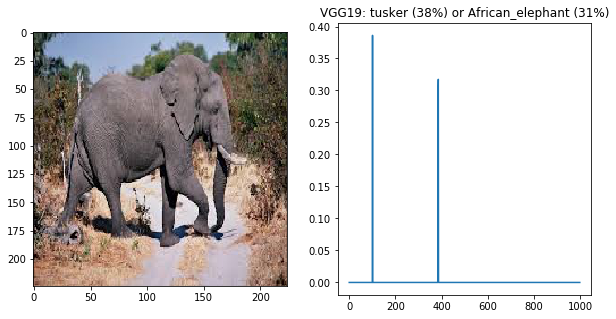

In [13]:
# classifying a single image from ImageNet
img = tensorflow.keras.preprocessing.image.load_img('../data/elephant.jpg', target_size=(224, 224)) 
x = tensorflow.keras.preprocessing.image.img_to_array(img)# (244,244,3)
x = np.expand_dims(x, axis=0) # (1,244,244,3)
x = tensorflow.keras.applications.vgg19.preprocess_input(x) # centered around 0

vgg19_prediction = vgg19_model.predict(x)
vgg19_decoded = tensorflow.keras.applications.vgg19.decode_predictions(vgg19_prediction, top=2)

fig, ax = plt.subplots(1,2,figsize =(10,5))
ax[0].imshow(img)
ax[1].plot(vgg19_prediction.ravel())
ax[1].set_title(f'VGG19: {vgg19_decoded[0][0][1]} ({int(vgg19_decoded[0][0][2]*100)}%)'
               + f' or {vgg19_decoded[0][1][1]} ({int(vgg19_decoded[0][1][2]*100)}%)')
plt.show()

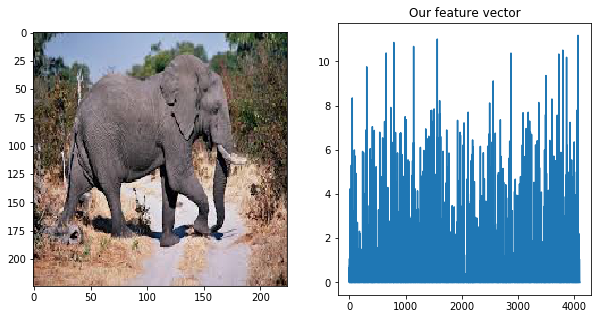

In [15]:
#%% Modifying VGG19
out = vgg19_model.get_layer('fc2').output
our_model = tensorflow.keras.models.Model(inputs=vgg19_model.input, outputs=out)
our_feature = our_model.predict(x)

fig, ax = plt.subplots(1,2,figsize =(10,5))
ax[0].imshow(img)
ax[1].plot(our_feature.ravel())
ax[1].set_title('Our feature vector')
plt.show()

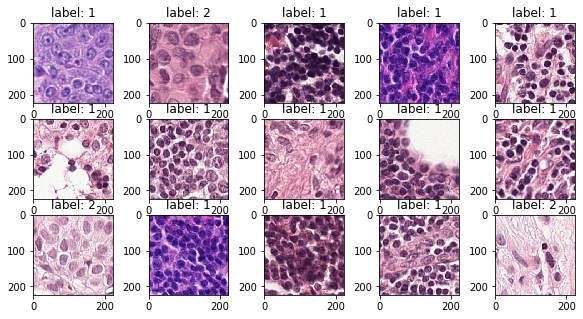

In [17]:
#%% Investigating histo images
histo_images = scipy.io.loadmat('../data/histo_images.mat')['histo_images']
histo_labels = scipy.io.loadmat('../data/histo_images.mat')['labels']

sample = np.random.permutation(histo_images.shape[3])[:15]
fig, ax = plt.subplots(3,5,figsize =(10,5))
for i in range(3):
    for j in range(5):
        k = j+i*5
        ax[i,j].imshow(histo_images[:,:,:,sample[k]])
        ax[i,j].set_title(f'label: {histo_labels[sample[k]].item()}')
plt.show()

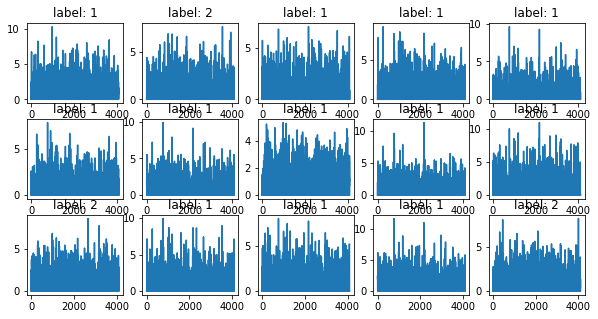

In [19]:
#%% Processing histo sample using our network
histo_x = histo_images.transpose((3,0,1,2))
histo_x = tensorflow.keras.applications.vgg19.preprocess_input(histo_x)
histo_features = our_model.predict(histo_x)

#%% visualizing features
fig, ax = plt.subplots(3,5,figsize =(10,5))
for i in range(3):
    for j in range(5):
        k = j+i*5
        ax[i,j].plot(histo_features[sample[k]])
        ax[i,j].set_title(f'label: {histo_labels[sample[k]].item()}')
plt.show()

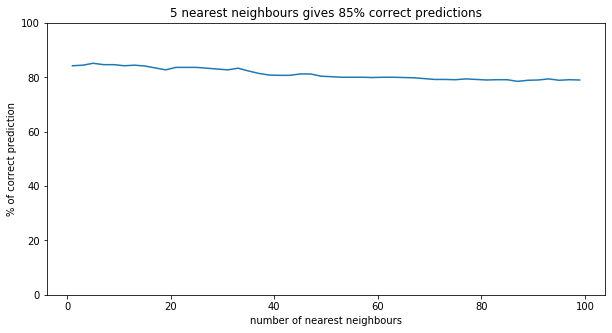

In [20]:
#%% computing pairwise distances and neighbours
a = np.expand_dims(histo_features, axis=2)        
d2 = np.square(a.transpose(0,2,1)- a.transpose(2,0,1)).sum(axis=2) # square of pairwise distances
S = np.argsort(d2, axis=1) # row-vise ordering, the first column is row index from diagonal, second column is first neighbour etc
L = histo_labels.ravel()[S] # labels of corresponding images

#%% finding the optimal number of neighbours
n = np.arange(1,100,2) # only odd number of neighbours for easier majority vote
miss = np.zeros(n.size)
for i in range(n.size): 
    t = L[:,0]
    p = L[:,1:1+n[i]].mean(axis=1).round()
    miss[i] = sum(abs(t-p))

miss /= histo_labels.size
miss *= 100 # miss in pct
hit = 100-miss
istar = np.argmax(hit)

fig, ax = plt.subplots(figsize =(10,5))
ax.plot(n,hit)
ax.set_ylim(0,100)
ax.set_xlabel('number of nearest neighbours')
ax.set_ylabel('% of correct prediction')
ax.set_title(f'{n[istar]} nearest neighbours gives {int(hit[istar])}% correct predictions')
plt.show()